In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
price_df = pd.read_csv('kospi.csv')

In [3]:
price_df.head()

,date,price
0,2005-04-26,944.46
1,2005-04-27,930.16
2,2005-04-28,917.73
3,2005-04-29,911.30
4,2005-05-02,918.42


In [4]:
price_df.describe()

,price
count,4800.000000
mean,2030.227556
std,476.189168
min,911.300000
25%,1775.250000
50%,2002.315000
75%,2343.167500
max,3305.210000


In [5]:
price_df.set_index(['date'],inplace=True)

In [6]:
n = 20
sigma = 2

In [7]:
def bollinger_band(price_df, n, sigma):
    bb = price_df.copy()
    bb['center'] = price_df['price'].rolling(n).mean() #중앙 이동평균선
    bb['ub'] = bb['center'] + sigma * price_df['price'].rolling(n).std() # 상단 밴드
    bb['lb'] = bb['center'] - sigma * price_df['price'].rolling(n).std() # 하단 밴드
    return bb

In [8]:
bollinger = bollinger_band(price_df, n, sigma)

In [10]:
base_date = '2006-01-01'

In [11]:
sample = bollinger.loc[base_date:]
sample.head()

,price,center,ub,lb
date,,,,
2006-01-02,1389.27,1344.4080,1388.877462,1299.938538
2006-01-03,1394.87,1348.3940,1396.001830,1300.786170
2006-01-04,1402.11,1352.4465,1403.900531,1300.992469
2006-01-05,1395.51,1355.9845,1409.123300,1302.845700
2006-01-06,1412.78,1360.4135,1417.048770,1303.778230


In [12]:
def create_trade_book(sample):
    book = sample[['price']].copy()
    book['trade'] = ''
    return (book)    

In [13]:
book = create_trade_book(sample)

In [15]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'price'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, 'price']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, 'price'] and sample.loc[i, 'price'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [16]:
book = tradings(sample,book)

In [20]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 144000
    sell = 0.0
    book['return'] = book['return'].astype(float)
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, 'price']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, 'price']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

진입일 :  2006-01-20 long 진입가격 :  1324.78
청산일 :  2006-03-31 long 진입가격 :  1324.78  |  long 청산가격 :  1359.6  | return: 1.0263
진입일 :  2006-05-16 long 진입가격 :  1382.11
청산일 :  2006-08-17 long 진입가격 :  1382.11  |  long 청산가격 :  1327.78  | return: 0.9607
진입일 :  2006-10-09 long 진입가격 :  1319.4
청산일 :  2006-11-09 long 진입가격 :  1319.4  |  long 청산가격 :  1399.44  | return: 1.0607
진입일 :  2006-12-08 long 진입가격 :  1390.43
청산일 :  2007-02-02 long 진입가격 :  1390.43  |  long 청산가격 :  1413.14  | return: 1.0163
진입일 :  2007-03-05 long 진입가격 :  1376.15
청산일 :  2007-04-04 long 진입가격 :  1376.15  |  long 청산가격 :  1483.41  | return: 1.0779
진입일 :  2007-08-16 long 진입가격 :  1691.98
청산일 :  2007-09-27 long 진입가격 :  1691.98  |  long 청산가격 :  1945.28  | return: 1.1497
진입일 :  2007-11-21 long 진입가격 :  1806.99
청산일 :  2008-04-03 long 진입가격 :  1806.99  |  long 청산가격 :  1763.63  | return: 0.976
진입일 :  2008-06-10 long 진입가격 :  1774.38
청산일 :  2008-12-10 long 진입가격 :  1774.38  |  long 청산가격 :  1145.87  | return: 0.6458
진입일 :  2009-02-20 long 진입가격 :  1065.

<Axes: xlabel='date'>

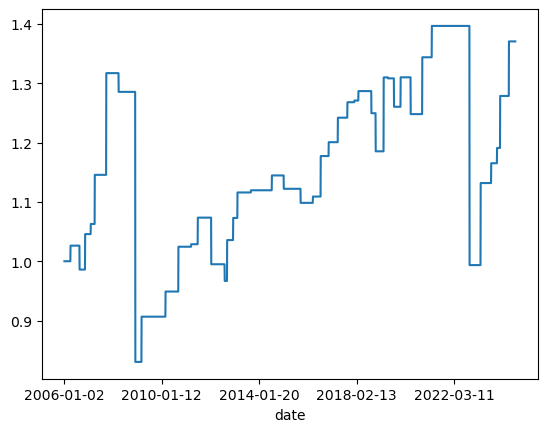

In [21]:
print(returns(book))
book['acc return'].plot()

In [22]:
book.tail()

,price,trade,return,acc return
date,,,,
2024-09-19,2580.80,buy,1.0,1.370686
2024-09-20,2593.37,buy,1.0,1.370686
2024-09-23,2602.01,buy,1.0,1.370686
2024-09-24,2631.68,buy,1.0,1.370686
2024-09-25,2630.53,buy,1.0,1.370686
